In [ ]:
%%capture
!pip install statsforecast

In [ ]:
##########
import os
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy.stats import norm
from statsforecast import StatsForecast
from statsforecast.models import (
    HoltWinters,
    CrostonClassic as Croston,
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoARIMA
)
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

# Set environment variable
os.environ['NIXTLA_ID_AS_COL'] = '1'

##########
# Read the data
Y_df = pd.read_csv('https://raw.githubusercontent.com/Haiqi-Z/bootcamp_Project1/main/Sales_Transactions_Dataset_Weekly.csv')



In [ ]:
Y_df.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,P1,11,12,10,8,13,12,14,21,6,...,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,P2,7,6,3,2,7,1,6,3,3,...,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,P3,7,11,8,9,10,8,7,13,12,...,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36
3,P4,12,8,13,5,9,6,9,13,13,...,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
4,P5,8,5,13,11,6,7,9,14,9,...,0.27,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40


In [ ]:
len(Y_df.columns)

107

Now we need to convert the current dataframe into a dataframe that follows the Nixtla's requirement. I read the documentation of the data, and figure out that we need to remove the MIN and MAX columns, and transfer the rest of the dataframe into a panel-data like data.

In [ ]:
# remove MIN,MAX columns
Y_df = Y_df.drop(columns=['MIN','MAX'],axis = 1)


Now, I chose to drop the normalized data and kept the raw W0-W51 data only.

In [ ]:
Y_df = Y_df.iloc[:,:-52]
Y_df

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,P1,11,12,10,8,13,12,14,21,6,...,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,...,2,4,5,1,1,4,5,1,6,0
2,P3,7,11,8,9,10,8,7,13,12,...,6,14,5,5,7,8,14,8,8,7
3,P4,12,8,13,5,9,6,9,13,13,...,9,10,3,4,6,8,14,8,7,8
4,P5,8,5,13,11,6,7,9,14,9,...,7,11,7,12,6,6,5,11,8,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,P815,0,0,1,0,0,2,1,0,0,...,0,1,1,0,0,1,0,0,2,0
807,P816,0,1,0,0,1,2,2,6,0,...,3,3,4,2,4,5,5,5,6,5
808,P817,1,0,0,0,1,1,2,1,1,...,2,0,0,2,2,0,0,0,4,3
809,P818,0,0,0,1,0,0,0,0,1,...,0,0,0,1,1,0,0,0,2,0


In [ ]:
Y_df = pd.melt(Y_df, id_vars=['Product_Code'], var_name='Week', value_name='Sales')

Y_df

,Product_Code,Week,Sales
0,P1,W0,11
1,P2,W0,7
2,P3,W0,7
3,P4,W0,12
4,P5,W0,8
...,...,...,...
42167,P815,W51,0
42168,P816,W51,5
42169,P817,W51,3
42170,P818,W51,0


In [ ]:
Y_df['Week'] = Y_df['Week'].str.replace('W', '').astype(int)
Y_df

,Product_Code,Week,Sales
0,P1,0,11
1,P2,0,7
2,P3,0,7
3,P4,0,12
4,P5,0,8
...,...,...,...
42167,P815,51,0
42168,P816,51,5
42169,P817,51,3
42170,P818,51,0


In [ ]:
Y_df.rename(columns = {'Product_Code': 'unique_id','Week':'ds','Sales':'y'},inplace = True)

In [ ]:
Y_df.dropna(inplace = True)

In [ ]:
Y_df

,unique_id,ds,y
0,P1,0,11
1,P2,0,7
2,P3,0,7
3,P4,0,12
4,P5,0,8
...,...,...,...
41366,P6,51,6
41367,P7,51,1
41368,P8,51,9
41369,P9,51,13


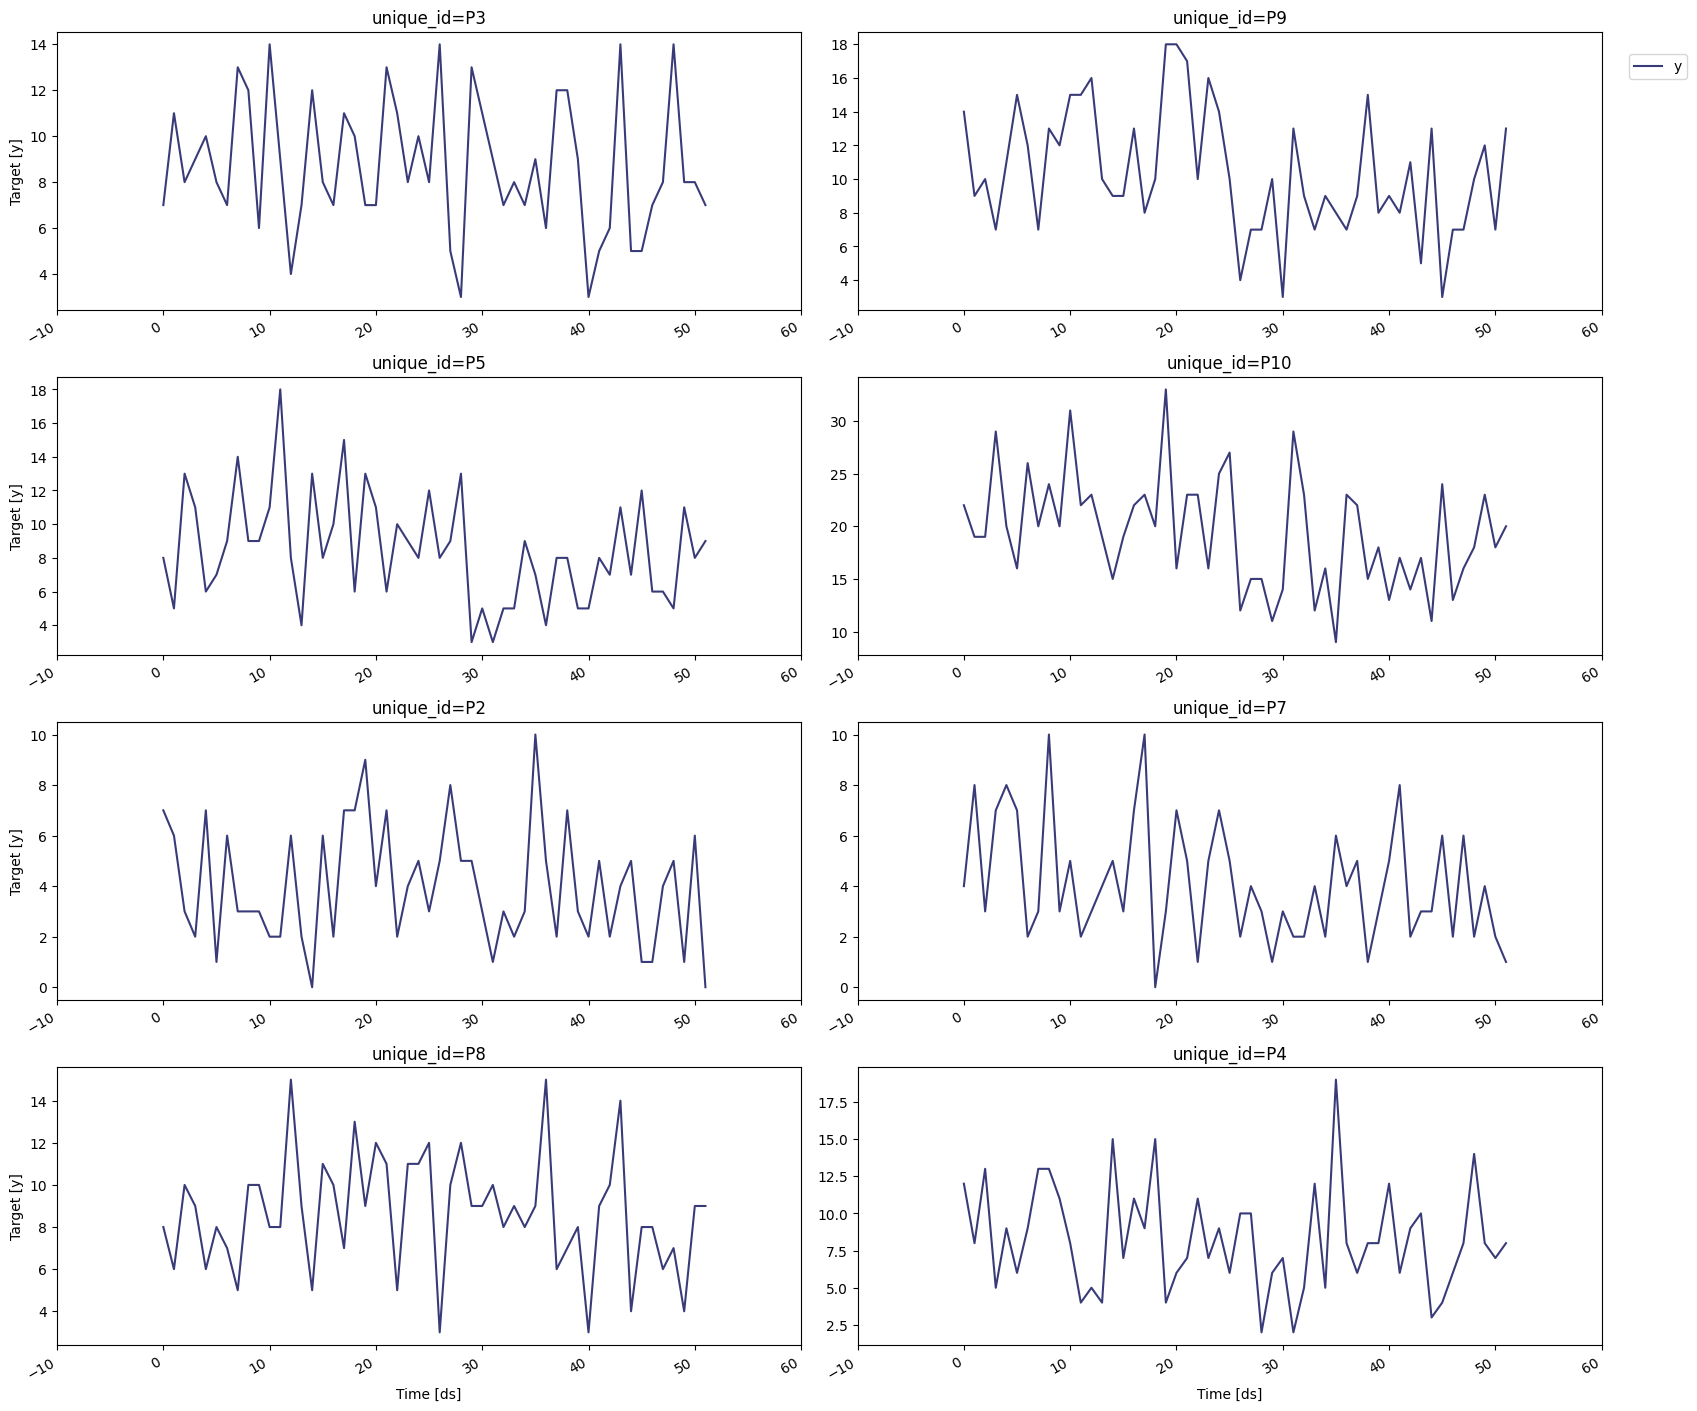

In [ ]:
# Select subset of data
uids = Y_df['unique_id'].unique()[:10]
Y_df = Y_df.query('unique_id in @uids')
Y_df = Y_df.groupby('unique_id').tail(7 * 24)

##########
# Explore data
StatsForecast.plot(Y_df)



1. HoltWinters: Triple exponential smoothing, good for data with both trend and seasonality.
1. Croston: Designed for intermittent demand forecasting.
1. SeasonalNaive(season_length=24): Uses the value from the same time in the previous season. The season_length=24 suggests hourly data with daily seasonality.
1. HistoricAverage: Uses the mean of all historical data points.
1. DOT (Dynamic Optimized Theta): A variant of the Theta method, good for data with seasonality.

In [ ]:
##########
# Define models
models = [
    HoltWinters(),
    Croston(),
    SeasonalNaive(season_length=24),
    HistoricAverage(),
    DOT(season_length=24),
    # AutoARIMA(season_length=24) ## slightly slow ignoring for now
]

#The season_length=24 refers to hourly data with daily seasonality.

# Instantiate StatsForecast
sf = StatsForecast(
    models=models,
    freq=1,
    fallback_model = SeasonalNaive(season_length=7), ## if other models fail
    n_jobs=-1,
)



* df=Y_df: The input data frame.
* h=52: Forecast horizon of 52 time units (as we have 52-week sales in this dataframe).
* level=[90]: Generates 90% prediction intervals.

In [ ]:
# Generate forecasts
forecasts_df = sf.forecast(df=Y_df, h=52, level=[90])

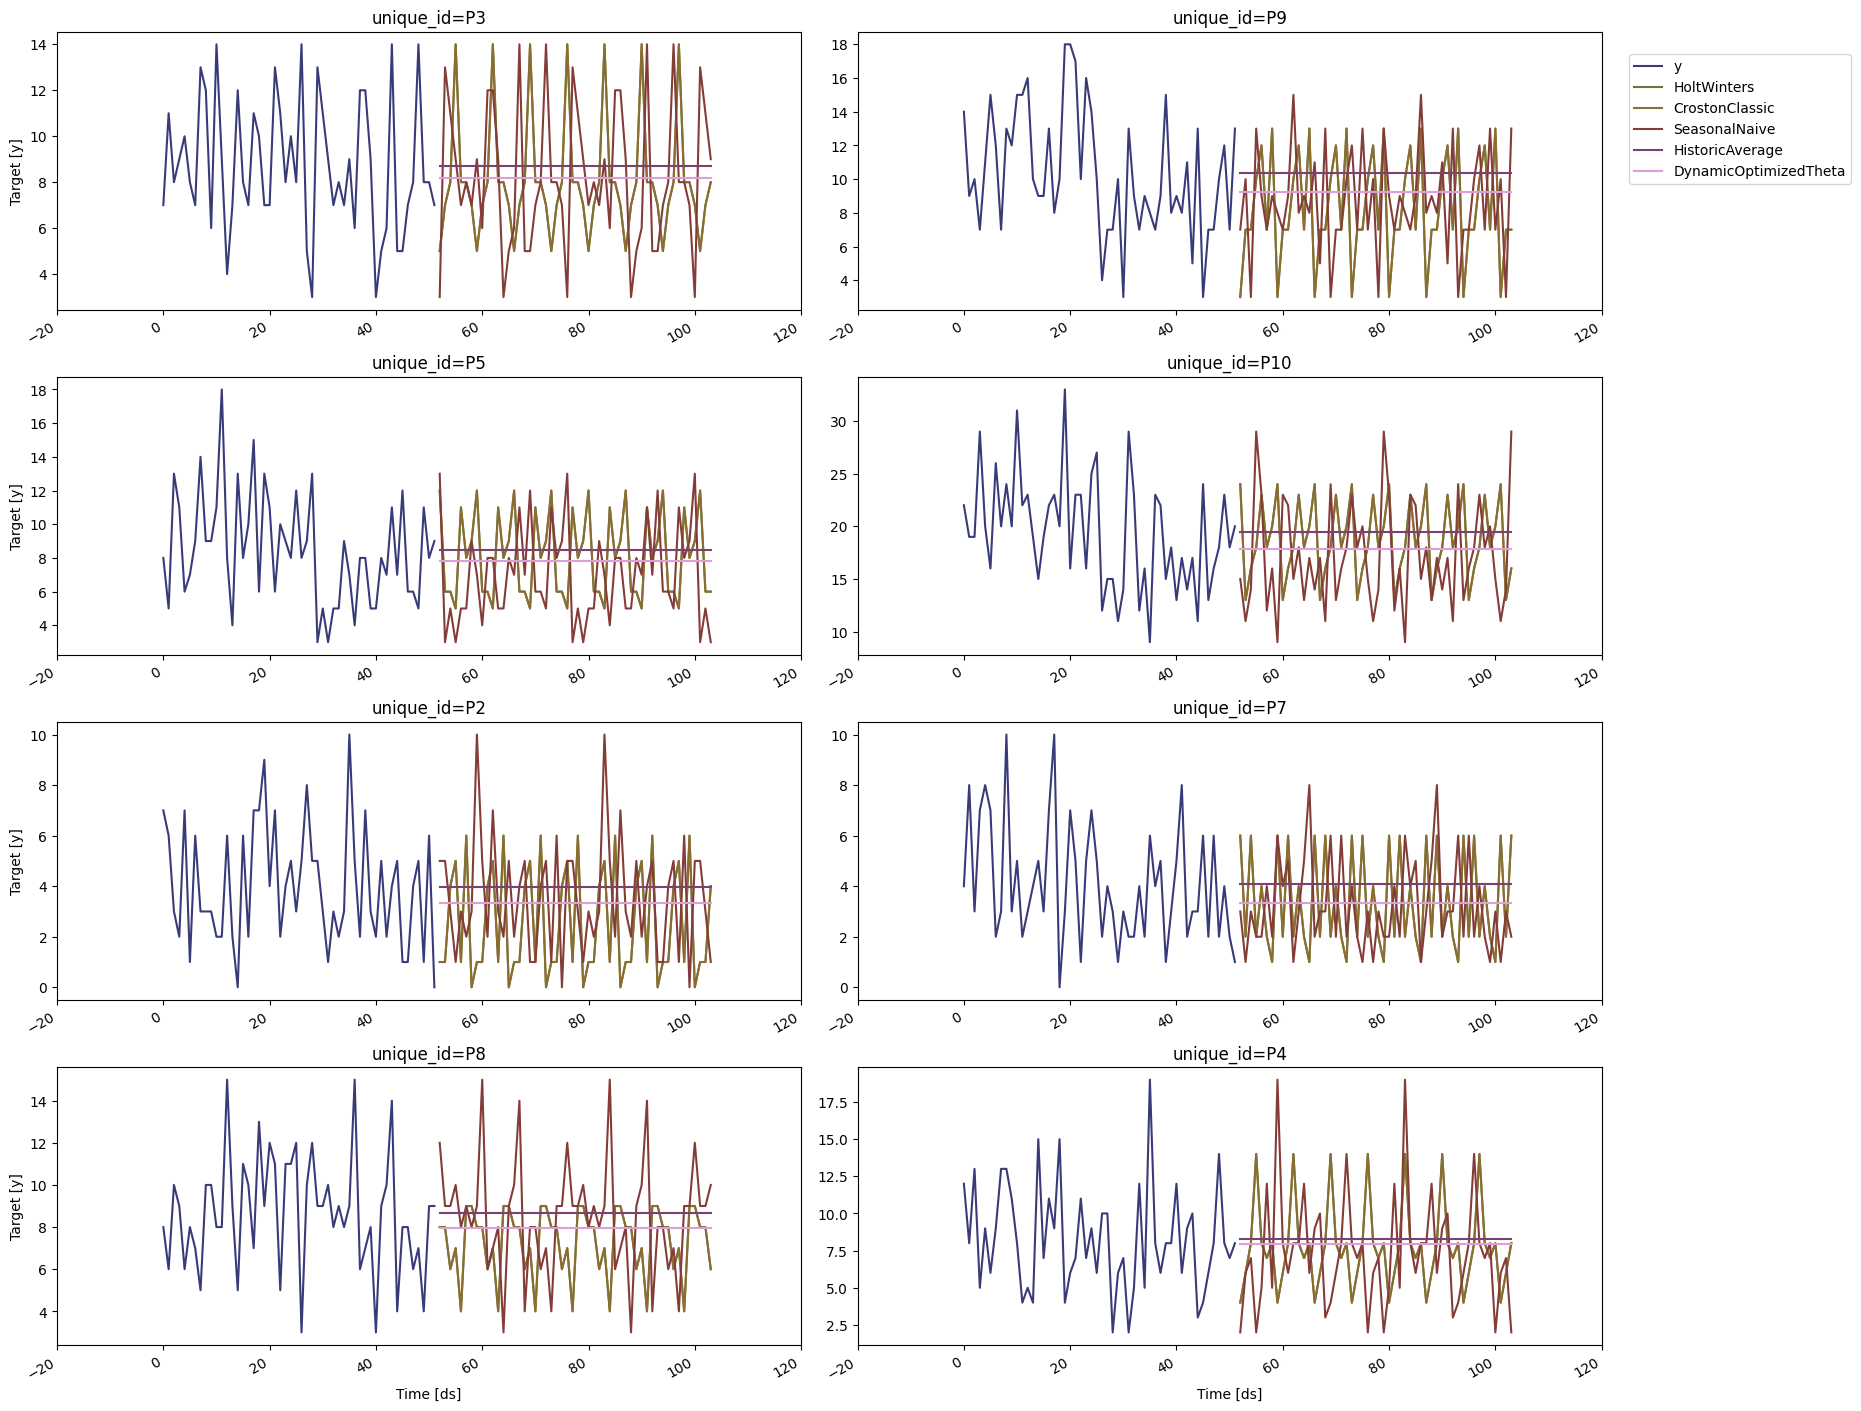

In [ ]:
##########
# Plot forecasts
sf.plot(Y_df, forecasts_df)

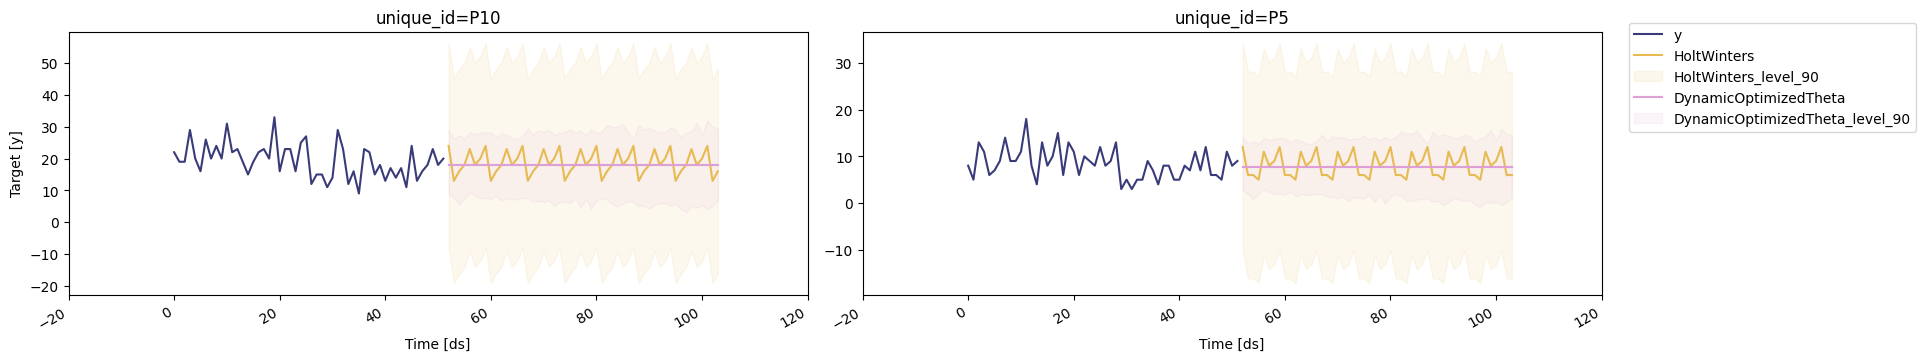

In [ ]:
sf.plot(Y_df, forecasts_df, models=["HoltWinters","DynamicOptimizedTheta"], unique_ids=["P10", "P5"], level=[90])


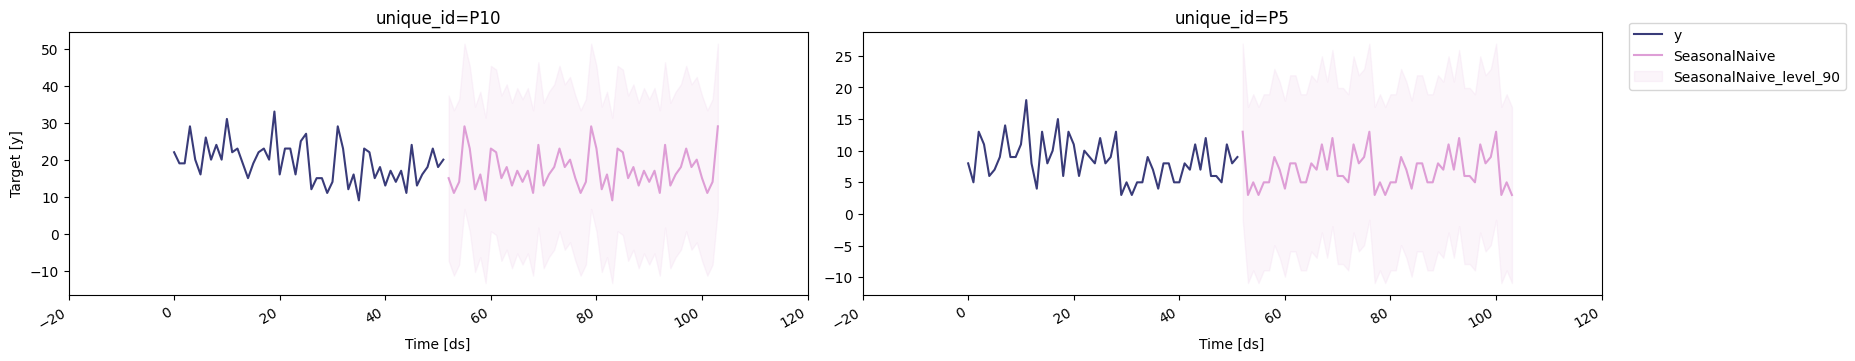

In [ ]:
sf.plot(Y_df, forecasts_df, models=["SeasonalNaive"], unique_ids=["P10", "P5"], level=[90])

In [ ]:
evaluation_df

,HoltWinters,CrostonClassic,SeasonalNaive,HistoricAverage,DynamicOptimizedTheta,best_model
unique_id,,,,,,
P1,11.500000,13.086628,20.500000,16.922182,12.916806,HoltWinters
P10,33.000000,9.989484,37.666668,12.254570,10.095138,CrostonClassic
P2,6.333333,6.102057,11.666667,6.821362,6.048426,DynamicOptimizedTheta
P3,25.666666,6.557438,12.000000,5.889729,6.603153,HistoricAverage
P4,19.833334,7.470128,11.333333,6.651386,7.561115,HistoricAverage
P5,6.666667,4.380797,5.833333,5.431475,4.359056,DynamicOptimizedTheta
P6,14.333333,9.434787,15.500000,7.641933,9.494280,HistoricAverage
P7,7.833333,4.017141,6.166667,4.843415,3.973062,DynamicOptimizedTheta
P8,16.500000,5.080040,25.166666,5.965186,4.993572,DynamicOptimizedTheta


In [ ]:
crossvaldation_df

,unique_id,ds,cutoff,y,HoltWinters,CrostonClassic,SeasonalNaive,HistoricAverage,DynamicOptimizedTheta
0,P1,46,45,12.0,17.0,9.153559,7.0,9.956522,9.110353
1,P1,47,45,3.0,7.0,9.153559,12.0,9.956522,9.110353
2,P1,48,45,7.0,11.0,9.153559,5.0,9.956522,9.110353
3,P1,49,45,6.0,4.0,9.153559,9.0,9.956522,9.110353
4,P1,50,45,5.0,7.0,9.153559,7.0,9.956522,9.110353
5,P1,51,45,10.0,8.0,9.153559,10.0,9.956522,9.110353
6,P10,46,45,13.0,18.0,17.431829,23.0,19.608696,17.345423
7,P10,47,45,16.0,13.0,17.431829,16.0,19.608696,17.345423
8,P10,48,45,18.0,17.0,17.431829,25.0,19.608696,17.345423
9,P10,49,45,23.0,14.0,17.431829,27.0,19.608696,17.345423


In [ ]:
evaluation_df

,HoltWinters,CrostonClassic,SeasonalNaive,HistoricAverage,DynamicOptimizedTheta,best_model
unique_id,,,,,,
P1,11.500000,13.086628,20.500000,16.922182,12.916806,HoltWinters
P10,33.000000,9.989484,37.666668,12.254570,10.095138,CrostonClassic
P2,6.333333,6.102057,11.666667,6.821362,6.048426,DynamicOptimizedTheta
P3,25.666666,6.557438,12.000000,5.889729,6.603153,HistoricAverage
P4,19.833334,7.470128,11.333333,6.651386,7.561115,HistoricAverage
P5,6.666667,4.380797,5.833333,5.431475,4.359056,DynamicOptimizedTheta
P6,14.333333,9.434787,15.500000,7.641933,9.494280,HistoricAverage
P7,7.833333,4.017141,6.166667,4.843415,3.973062,DynamicOptimizedTheta
P8,16.500000,5.080040,25.166666,5.965186,4.993572,DynamicOptimizedTheta


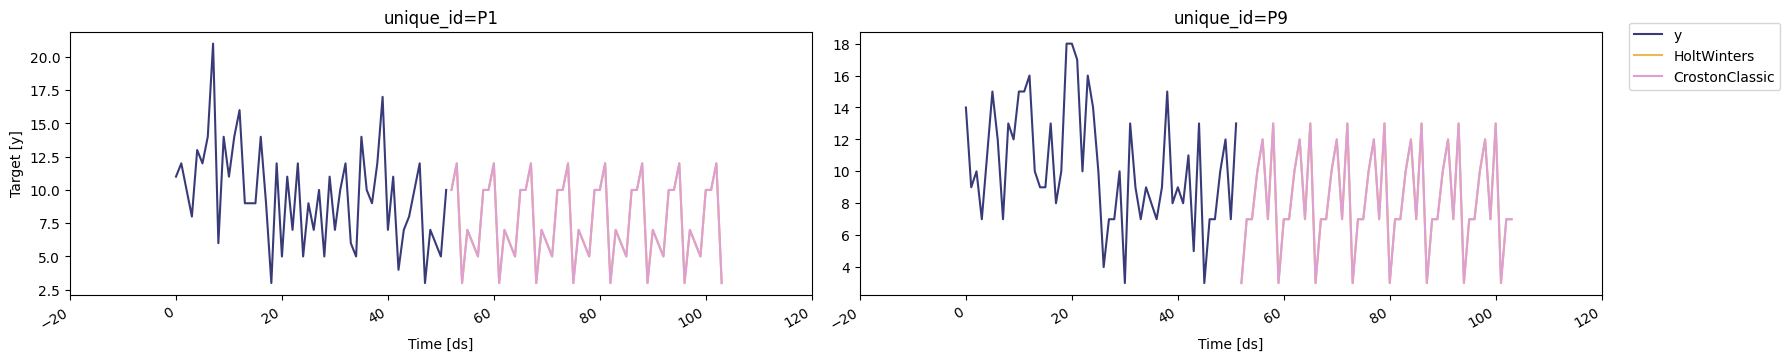

In [ ]:
##########
# Cross-validation
crossvaldation_df = sf.cross_validation(
    df=Y_df,
    h=6,
    step_size=6,
    n_windows=1
)

##########
# Evaluation function
def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True)
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

# Evaluate models
evaluation_df = evaluate_cross_validation(crossvaldation_df, mse)

# Create summary
summary_df = evaluation_df.groupby('best_model').size().sort_values().to_frame()
summary_df.reset_index().columns = ["Model", "Nr. of unique_ids"]

# Plot best model for specific IDs
seasonal_ids = evaluation_df.query('best_model == "HoltWinters"').index
sf.plot(Y_df, forecasts_df, unique_ids=seasonal_ids, models=["HoltWinters","CrostonClassic"])

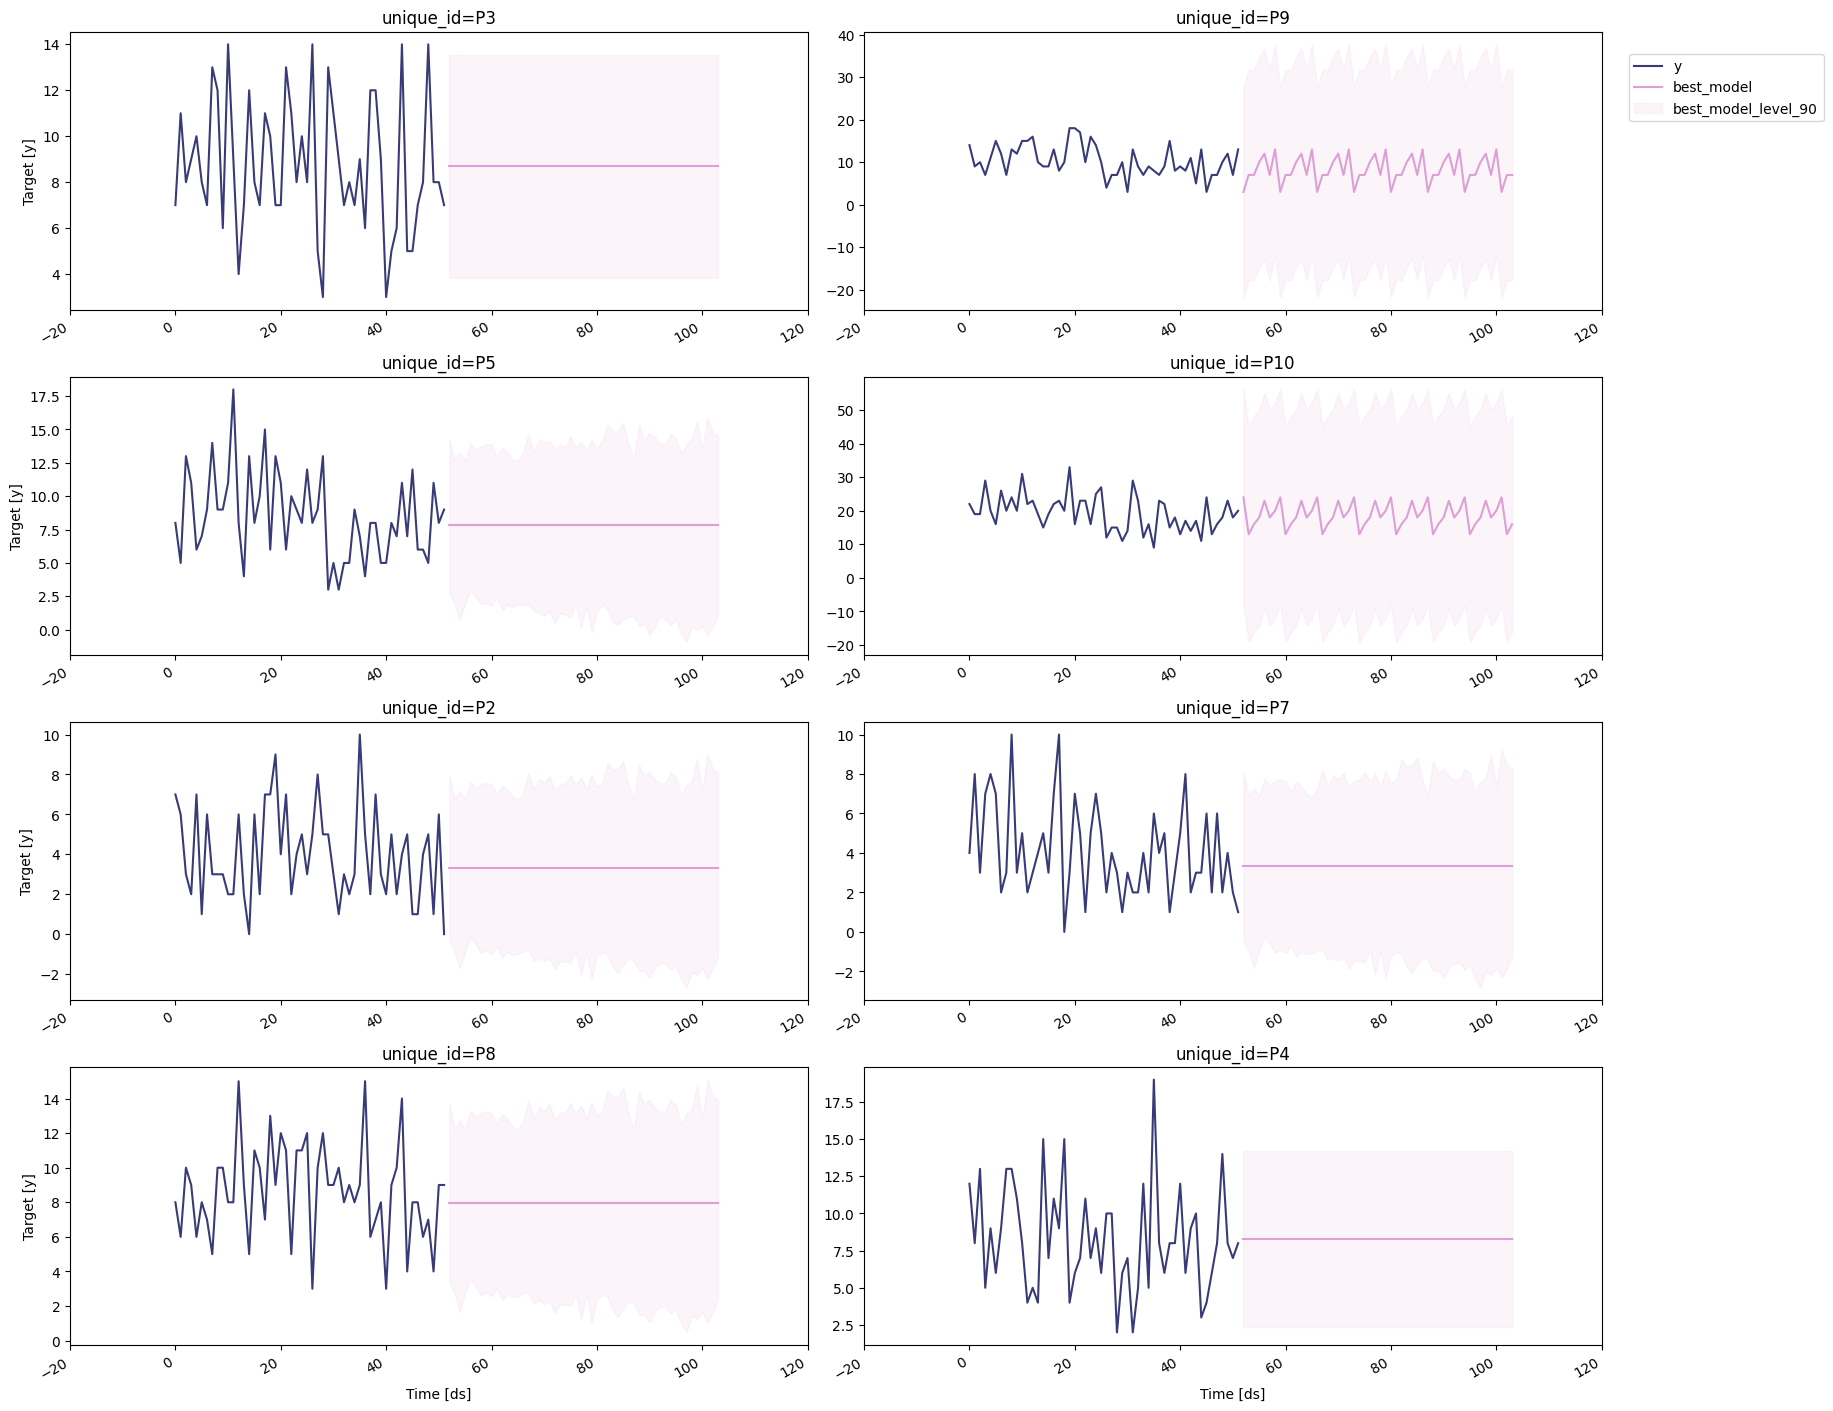

In [ ]:
##########
# Select best model for each series
def get_best_model_forecast(forecasts_df, evaluation_df):
    df = forecasts_df.set_index(['unique_id', 'ds']).stack().to_frame().reset_index(level=2)
    df.columns = ['model', 'best_model_forecast']
    df = df.join(evaluation_df[['best_model']])
    df = df.query('model.str.replace("-lo-90|-hi-90", "", regex=True) == best_model').copy()
    df.loc[:, 'model'] = [model.replace(bm, 'best_model') for model, bm in zip(df['model'], df['best_model'])]
    df = df.drop(columns='best_model').set_index('model', append=True).unstack()
    df.columns = df.columns.droplevel()
    df.columns.name = None
    df = df.reset_index()
    return df

# Get best model forecasts
prod_forecasts_df = get_best_model_forecast(forecasts_df, evaluation_df)

# Plot final results
sf.plot(Y_df, prod_forecasts_df, level=[90])

##########